# Predicting Car Prices - ML (k-nearest neighbors)


## Goal: 

Using a dataset of car features and prices, use the k-nearest neighbors ML algorithm to develop a predictive model for determining a car's market value.

## Outcome:

After testing each continuous feature,'horsepower' was found to be the most accurate univariate predictor of car price for this dataset. This model returned the average price of the nearest 5 neighbors and had a root mean error of $3,958.

Several multivariate models outperformed 'horsepower'. The strongest model included 'horsepower', 'curb-weight', and 'highway-mpg' and measured price for only the nearest 1 neighbor. This model had a root mean error of $2,635.

## Libraries used

1. **Pandas** - data import and dataframes
2. **Numpy** - vectorized calculations
3. **Matplotlib** - visualization
4. **SciKit Learn** 
 - KNeighbors model, 
 - error calculation, 
 - cross validation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

## Dataset

The data that I will be using for training and prediction comes from [UC - Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/automobile). The dataset contains car specifications including price, insurance risk ratings, and information about normalized losses (insurance). The dataset is from 1985 and was donated to UCI in 1989, so pricing will be relavent to that era.

#### Attributes and range of values (from documentation):
1. **symboling**: -3, -2, -1, 0, 1, 2, 3.   (This denotes relative risk, with -3 being relatively the least risky compared to peers and +3 being the most risky relative to peers)
2. **normalized-losses**: continuous from 65 to 256. 
3. **make**: 
alfa-romero, audi, bmw, chevrolet, dodge, honda, 
isuzu, jaguar, mazda, mercedes-benz, mercury, 
mitsubishi, nissan, peugot, plymouth, porsche, 
renault, saab, subaru, toyota, volkswagen, volvo 

4. **fuel-type**: diesel, gas. 
5. **aspiration**: std, turbo. 
6. **num-of-doors**: four, two. 
7. **body-style**: hardtop, wagon, sedan, hatchback, convertible. 
8. **drive-wheels**: 4wd, fwd, rwd. 
9. **engine-location**: front, rear. 
10. **wheel-base**: continuous from 86.6 120.9. 
11. **length**: continuous from 141.1 to 208.1. 
12. **width**: continuous from 60.3 to 72.3. 
13. **height**: continuous from 47.8 to 59.8. 
14. **curb-weight**: continuous from 1488 to 4066. 
15. **engine-type**: dohc, dohcv, l, ohc, ohcf, ohcv, rotor. 
16. **num-of-cylinders**: eight, five, four, six, three, twelve, two. 
17. **engine-size**: continuous from 61 to 326. 
18. **fuel-system**: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi. 
19. **bore**: continuous from 2.54 to 3.94. 
20. **stroke**: continuous from 2.07 to 4.17. 
21. **compression-ratio**: continuous from 7 to 23. 
22. **horsepower**: continuous from 48 to 288. 
23. **peak-rpm**: continuous from 4150 to 6600. 
24. **city-mpg**: continuous from 13 to 49. 
25. **highway-mpg**: continuous from 16 to 54. 
26. **price**: continuous from 5118 to 45400.

## Data Import

In [2]:

cols = ['symboling', 'normalized-losses', 
        'make', 'fuel-type', 'aspiration', 
        'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 
        'wheel-base', 'length', 'width', 
        'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 
        'fuel-system', 'bore', 'stroke', 
        'compression-rate', 'horsepower', 
        'peak-rpm', 'city-mpg', 
        'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

In [3]:
print(cars.head())
print(cars.shape)

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compressi

## Feature overview / data cleanup

#### Limit Data to continuous numeric features

In [4]:
numeric_cols = ['normalized-losses', 'wheel-base', 'length', 
                'width', 'height', 'curb-weight', 'bore', 
                'stroke', 'compression-rate', 'horsepower', 
                'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars_numeric = cars[numeric_cols].copy()

#### Substitute np.nan for '?' missing values.

In [5]:
cars_numeric = cars_numeric.replace('?', np.nan)

#### 'normalized-losses' missing values

This column contains 41 missing values, 20% of dataset. This field also describes insurance claim info and not a car-specification, so I feel comfortable removing it from the model.

In [6]:
cars_numeric = cars_numeric.drop(columns=['normalized-losses'])

#### Convert all columns to numeric

In [7]:
cars_numeric = cars_numeric.apply(pd.to_numeric)
print(cars_numeric.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
wheel-base          205 non-null float64
length              205 non-null float64
width               205 non-null float64
height              205 non-null float64
curb-weight         205 non-null int64
bore                201 non-null float64
stroke              201 non-null float64
compression-rate    205 non-null float64
horsepower          203 non-null float64
peak-rpm            203 non-null float64
city-mpg            205 non-null int64
highway-mpg         205 non-null int64
price               201 non-null float64
dtypes: float64(10), int64(3)
memory usage: 20.9 KB
None


#### Remaining missing values

A small number of missing values remain (5% of remaining rows), notably the 4 missing values in price, which is the target field for the regression model. Dropping all records that are missing the target field and inputing all others ('bore', 'stroke', 'horsepower', 'peak-rpm') by filling them in with their column means.

In [8]:
print(cars_numeric.isnull().sum())
print(cars_numeric.shape)
cars_numeric = cars_numeric.dropna(subset=['price'])
cars_numeric = cars_numeric.fillna(cars_numeric.mean())
print("*****Validate*******")
print(cars_numeric.isnull().sum())
print(cars_numeric.shape)

wheel-base          0
length              0
width               0
height              0
curb-weight         0
bore                4
stroke              4
compression-rate    0
horsepower          2
peak-rpm            2
city-mpg            0
highway-mpg         0
price               4
dtype: int64
(205, 13)
*****Validate*******
wheel-base          0
length              0
width               0
height              0
curb-weight         0
bore                0
stroke              0
compression-rate    0
horsepower          0
peak-rpm            0
city-mpg            0
highway-mpg         0
price               0
dtype: int64
(201, 13)


## Normalize Data

In order to account for multiple scales used in measuring the various columns, I will be normalizing each column (except the target, price) to a range between 0 and 1 using min-max normalization.

In [9]:
cars_norm= (cars_numeric-cars_numeric.min())/(cars_numeric.max()-cars_numeric.min())
cars_norm['price'] = cars_numeric['price']


In [10]:
print(cars_norm.head())

   wheel-base    length     width    height  curb-weight      bore    stroke  \
0    0.058309  0.413433  0.324786  0.083333     0.411171  0.664286  0.290476   
1    0.058309  0.413433  0.324786  0.083333     0.411171  0.664286  0.290476   
2    0.230321  0.449254  0.444444  0.383333     0.517843  0.100000  0.666667   
3    0.384840  0.529851  0.504274  0.541667     0.329325  0.464286  0.633333   
4    0.373178  0.529851  0.521368  0.541667     0.518231  0.464286  0.633333   

   compression-rate  horsepower  peak-rpm  city-mpg  highway-mpg    price  
0            0.1250    0.294393  0.346939  0.222222     0.289474  13495.0  
1            0.1250    0.294393  0.346939  0.222222     0.289474  16500.0  
2            0.1250    0.495327  0.346939  0.166667     0.263158  16500.0  
3            0.1875    0.252336  0.551020  0.305556     0.368421  13950.0  
4            0.0625    0.313084  0.551020  0.138889     0.157895  17450.0  


## Univariate Model

Which single features are the best predictors of price when using KNeighbors?

To answer this question, I am building a function to do the following:
1. Randomize the order of the dataset.
2. Split a dataframe into training and testing partitions (50/50)
2. Instantiate the model, a sklearn KNeighborsRegressor class .
3. Fit the model on the training partition.
4. Test the model on the testing partition.
5. Calculate mean_squared_error for the prediction vs. actuals.
6. Swap training and testing data set and reiterate steps 2-5
7. Average the errors from iteration 1 and iteration 2.
8. Use the average of the two errors to calculate the root mean squared error.

This function can be used to test each feature at various k hyperparameter values to determine which features make the best univariate price predictors and their optimal k values.

#### Results (k=5)

When using the default k=5 neighbors, the best univariate features for predicting price are horsepower, curb-weight, and highway-mpg. The height feature has the highest error.

| Feature | RMSE Value |
| - | - |
| horsepower | 3958 |
| curb-weight | 4133 |
| highway-mpg | 4398 |
| city-mpg | 4484 |
| width | 4506 |
| length | 5592 |
| wheel-base | 5650 |
| compression-rate | 6379 |
| bore | 6496 |
| stroke | 7680 |
| peak-rpm | 7712 |
| height | 7964 |


In [11]:
#Model Train/Test Function
def knn_train_test(model_features, target_col, df, k=5):
    mses = []
    
    #randomize dataset
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index).copy()
    
    #Iteration 1:
    #partition
    last_training_row = int(rand_df.shape[0] / 2)
    train_df = rand_df[:last_training_row].copy()
    test_df = rand_df[last_training_row:].copy()
    
    #Initialize model and fit training data
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='auto')
    knn.fit(train_df[model_features], train_df[target_col])
    
    #Predict Test Data Target Col
    predictions = knn.predict(test_df[model_features])
    
    #calculate error of prediction
    mse = mean_squared_error(test_df[target_col], predictions)
    mses.append(mse)
    
    ##Iteration 2: (Cross Validation)
    #partition
    test_df = rand_df[:last_training_row].copy()
    train_df = rand_df[last_training_row:].copy()
    
    #Initialize model and fit training data
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='auto')
    knn.fit(train_df[model_features], train_df[target_col])
    
    #Predict Test Data Target Col
    predictions = knn.predict(test_df[model_features])
    
    #calculate error of prediction
    mse = mean_squared_error(test_df[target_col], predictions)
    mses.append(mse)
    
    #average mses and return sqrt of result
    avg_mse = sum(mses) / len(mses)
    avg_rmse = np.sqrt(avg_mse)
    
    return avg_rmse

In [12]:
#Test each feature using default k=5
rmses = {}

for col in cars_norm.columns:
    if col == 'price':
        pass
    else:
        rmse = knn_train_test(model_features=[col], target_col='price', df=cars_norm)
        rmses[col] = rmse
print("RMSE Values in Dollars")
print("----------------------")
for key, value in rmses.items():
    print("{}: {}".format(key, round(value,0)))


RMSE Values in Dollars
----------------------
width: 4506.0
stroke: 7680.0
length: 5592.0
curb-weight: 4133.0
bore: 6496.0
highway-mpg: 4398.0
horsepower: 3958.0
peak-rpm: 7712.0
compression-rate: 6379.0
height: 7964.0
wheel-base: 5650.0
city-mpg: 4484.0


#### Grid test k-values

While horsepower performed the best in the univariate model at k=5, this may not be the best performing feature at other k values. Moreover, k=5 may not be the strongest value for the horsepower feature. In order to test, I am running the previous univariate model, but over all values of k from 1-14.

#### Results

After testing each feature again for k values from 1-14, horsepower remains the strongest feature in the univariate model when k < 7. k=2 is an improvement over the default value, k=5, with an rmse of 3,761.

3761.450344078112


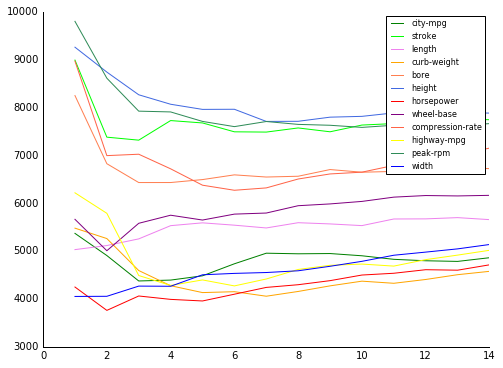

In [13]:
#test each feature at various k settings and plot results

fig, ax = plt.subplots(figsize=(8, 6))

col_colors = {"horsepower": 'red',
          "curb-weight": 'orange',
          "highway-mpg": 'yellow',
          "city-mpg": 'green',
          "width": 'blue',
          "length":  'violet',
          "wheel-base": 'purple',
          "compression-rate": 'tomato',
          "bore": "coral",
          "stroke": "lime",
          "peak-rpm": 'seagreen',
          "height": "royalblue"}

for column, color_name in col_colors.items():
    column_rmses = []
    
    #calculate rmse over range of k values for each feature
    if column == 'price':
        pass
    else:
        for k in range(1,15):
            rmse = knn_train_test(model_features=[column], target_col='price', df=cars_norm, k=k)
            column_rmses.append((k, rmse))
    #plot        
    x_val = [x[0] for x in column_rmses]
    y_val = [x[1] for x in column_rmses]
    plt.plot(x_val, y_val, c=color_name, label=column)
    plt.legend(prop={'size': 8})
    
#cleanup plot
# Hide the right and top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Hide xticks except bottom
ax.tick_params(top=False, left=False, right=False, bottom=False)
    
lowest_rmse = rmse = knn_train_test(model_features=['horsepower'], target_col='price', df=cars_norm, k=2)
print(lowest_rmse)
            



## Cross-validation variation

The previous models split the data into test/train sets with 50% of the data in each. In order to incorporate more data into the training model, I'm running a variation using KFolds cross-validation. The new function will partition the data into 5 sets and use each as the test set while the remaining 4 serve as the training sets. The errors from each iteration will be averaged together to create one RMSE value for each feature.

#### Result

In the KFolds cross-validation variation of the model, horsepower is once again the strongest feature. In the grid test of k, k=5 resulted in the lowest error.

In [14]:
#Model knn kfolds cross-validation function
def knn_kfolds(model_features, target_col, df, k, n_folds=5): 
    #randomize dataset
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index).copy()
    
    #k-folds cross validation using knn model
    knn = KNeighborsRegressor(n_neighbors=k)
    kf = KFold(n_splits=n_folds, shuffle=True)
    mses = cross_val_score(knn, np.array(rand_df[model_features]), rand_df[target_col], scoring='neg_mean_squared_error', cv=kf)
    
    #average mses and return sqrt of result
    avg_mse = sum(abs(mses)) / len(mses)
    avg_rmse = np.sqrt(avg_mse)
    
    return avg_rmse

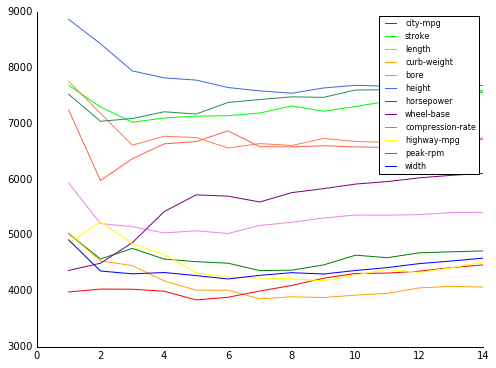

In [15]:
#Grid test and plot
fig2, ax2 = plt.subplots(figsize=(8, 6))

col_colors = {"horsepower": 'red',
          "curb-weight": 'orange',
          "highway-mpg": 'yellow',
          "city-mpg": 'green',
          "width": 'blue',
          "length":  'violet',
          "wheel-base": 'purple',
          "compression-rate": 'tomato',
          "bore": "coral",
          "stroke": "lime",
          "peak-rpm": 'seagreen',
          "height": "royalblue"}

for column, color_name in col_colors.items():
    column_rmses = []
    
    #calculate rmse over range of k values for each feature
    if column == 'price':
        pass
    else:
        for k in range(1,15):
            rmse = knn_kfolds(model_features=[column], target_col='price', df=cars_norm, k=k)
            column_rmses.append((k, rmse))
    #plot        
    x_val = [x[0] for x in column_rmses]
    y_val = [x[1] for x in column_rmses]
    plt.plot(x_val, y_val, c=color_name, label=column)
    plt.legend(prop={'size': 8})
    
#cleanup plot
# Hide the right and top spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#Hide xticks except bottom
ax2.tick_params(top=False, left=False, right=False, bottom=False)



## Multivariate Models

Now that I have an understanding of how features perform in univariate models, it is time to start combining them into multivariate models and observing changes in RMSE. To select features for each model, I'll begin with the top two univariate features and then add the next best feature each iteration until I reach five features. Each iteration will use a grid test for k.

#### Results

The highest performing model uses the top three features, 'horsepower', 'curb-weight', and 'highway-mpg', at k=1. This final model is able to predict price with an average error of 2,635.

In [16]:
top_two_features = ['horsepower','curb-weight']
top_three_features = ['horsepower','curb-weight', 'highway-mpg']
top_four_features = ['horsepower','curb-weight', 'highway-mpg', 'city-mpg']
top_five_features = ['horsepower','curb-weight', 'highway-mpg', 'city-mpg', 'width']

for n in range(1,26):
    rmses = []
    rmses.append(knn_kfolds(model_features=top_two_features, target_col='price', df=cars_norm, k=n))
    rmses.append(knn_kfolds(model_features=top_three_features, target_col='price', df=cars_norm, k=n))
    rmses.append(knn_kfolds(model_features=top_four_features, target_col='price', df=cars_norm, k=n))
    rmses.append(knn_kfolds(model_features=top_five_features, target_col='price', df=cars_norm, k=n))
    print('k = {} results:'.format(n))
    print(rmses)
    print("---------------")

k = 1 results:
[2783.0065993804474, 2694.6566661930306, 2635.2609125001686, 2804.943627971436]
---------------
k = 2 results:
[3012.442888741101, 2673.160745551019, 2798.196519150609, 2958.7671663438045]
---------------
k = 3 results:
[3034.6419438362036, 2925.5421642023452, 3013.104211826719, 2988.9323720499847]
---------------
k = 4 results:
[3046.2989547243847, 3056.05333160929, 3178.102682417983, 3120.8639389469076]
---------------
k = 5 results:
[3061.345729488673, 3235.6428432859084, 3314.899854725409, 3232.537933862267]
---------------
k = 6 results:
[3180.5908519908085, 3328.3765525191225, 3416.0325799594143, 3287.4574852970345]
---------------
k = 7 results:
[3296.3478366084023, 3419.1337933243503, 3478.0861491574183, 3367.199531869414]
---------------
k = 8 results:
[3411.893777571374, 3516.6250253001203, 3623.8383048966475, 3390.315168367845]
---------------
k = 9 results:
[3514.455480792072, 3649.6997700623124, 3731.3328566404484, 3478.617965349999]
---------------
k = 10 r